In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm

In [3]:
def n_triu(d):
    return (d-1)*d/2

def n_triu_inv(t, module=np):
    return int(1/2*(1 + module.sqrt(1 + 8*t)))

def make_cov_matrix(sigmas, C_triu, module=np):
    D = len(sigmas.tag.test_value if hasattr(sigmas, "tag") else sigmas)
    C = module.ones((D,D))
    Sigmas = module.diag(sigmas)
    # indices are always numpy
    idxu = np.triu_indices(D, 1)
    idxl = np.tril_indices(D, -1)
    if module.__name__ == "theano.tensor":
        C = tt.set_subtensor(C[idxu], C_triu)
        C = tt.set_subtensor(C[idxl], C_triu)
    elif module.__name__ == "numpy":
        C[idxu] = C_triu
        C[idxl] = C_triu
    return Sigmas.dot(C).dot(Sigmas)

# data 

In [4]:
D = 2
K = 3
mus = np.random.normal(scale=3, size=(K, D))
sigmas = np.random.uniform(high=1, size=(K, D))
covariances = np.empty((K, D, D))
for k in range(K):
    corr = np.random.uniform(low=-1, high=1, size=int(n_triu(D)))
    covariances[k] = make_cov_matrix(sigmas[k], corr)

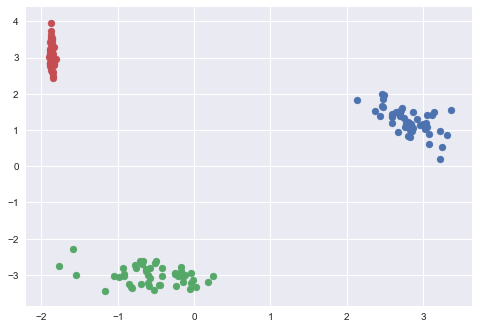

In [5]:
N_samples = 50
plt.figure()
data = []
for mu, cov in zip(mus, covariances):
    nxy = np.random.multivariate_normal(mu, cov, size=N_samples).astype("float32")
    data.append(nxy)
    plt.scatter(nxy[:,0], nxy[:,1])

data = np.concatenate(data)

# model

In [6]:
init_mean = np.mean(data, axis=0)
init_sigma = np.std(data, axis=0).astype(np.float32) / 10
idxu = np.triu_indices(D, 1)
init_corr = np.corrcoef(data, rowvar=0)[idxu].astype(np.float32)

In [7]:
def multivariatenormal(init_mean, init_sigma, init_corr, suffix="", dist=False):
    if not isinstance(suffix, str):
        suffix = str(suffix)
    D = len(init_sigma)
    
    sigma = pm.Lognormal('sigma' + suffix, np.zeros(D, dtype=np.float), np.ones(D), shape=D, testval=init_sigma)
    nu = pm.Uniform('nu' + suffix, 0, 5)
    C_triu = pm.LKJCorr('C_triu' + suffix, nu, D, testval=init_corr)
    cov = pm.Deterministic('cov' + suffix, make_cov_matrix(sigma, C_triu, module=tt))
    
    mu = pm.MvNormal('mu' + suffix, 0, cov, shape=2, testval=init_mean)

    return pm.MvNormal.dist(mu, cov) if dist else pm.MvNormal('mvn' + suffix, mu, cov)

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [8]:
K = 3
with pm.Model() as model:
    #alpha = pm.Gamma('alpha', 1., 1.)
    #beta = pm.Beta('beta', 1, alpha, shape=K)
    #w = pm.Deterministic('w', stick_breaking(beta))
    w = pm.Dirichlet('w', np.ones(K))
    obs = pm.Mixture('obs', w, [multivariatenormal(init_mean, init_sigma, init_corr, k, dist=True) for k in range(K)], observed=data)

ValueError: Input dimension mis-match. (input[0].shape[1] = 3, input[1].shape[1] = 2)

In [ ]:
w.tag.test_value

In [10]:
with model:
    trace = pm.sample(10000, pm.Metropolis())[5000::5]

100%|██████████| 10000/10000 [01:32<00:00, 107.82it/s]


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


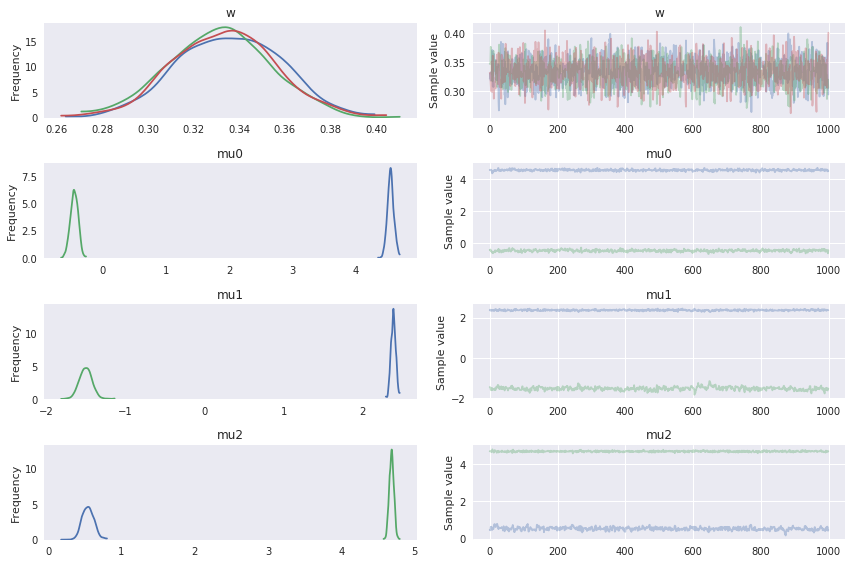

In [15]:
pm.traceplot(trace, varnames=["w", 'mu0', 'mu1', 'mu2']);

In [12]:
trace['mu0'].shape

(1000, 2)

In [14]:
trace[]

['w_stickbreaking_',
 'sigma0_log_',
 'nu0_interval_',
 'C_triu0',
 'mu0',
 'sigma1_log_',
 'nu1_interval_',
 'C_triu1',
 'mu1',
 'sigma2_log_',
 'nu2_interval_',
 'C_triu2',
 'mu2',
 'w',
 'sigma0',
 'nu0',
 'cov0',
 'sigma1',
 'nu1',
 'cov1',
 'sigma2',
 'nu2',
 'cov2']